# 🧼 Preprocesamiento para Visualización en Power BI

Este notebook tiene como único objetivo preparar una versión del dataset `df_train` adecuada para visualización en Power BI.

## 🎯 Objetivo

En lugar de preparar los datos para modelado, aquí eliminamos valores extremos (outliers) utilizando el método de los cuartiles (IQR), con el fin de:

- Evitar que valores anómalos distorsionen los gráficos en Power BI.
- Generar una visualización clara y representativa del comportamiento real de los datos.

## ⚠️ Importante

A diferencia del notebook de modelado, **en esta versión los outliers son eliminados (filtrados)**, y no recortados (`clip()`). Por lo tanto, los resultados **no son válidos para modelado predictivo** (ya que hay menos observaciones), sino exclusivamente para exploración visual.

## 📤 Resultado

Se genera un archivo `podcast_dataset_powerbi.csv` con los datos procesados y listos para ser importados en Power BI Desktop.


In [2]:
# Instala la librería kaggle
!pip install -q kaggle

# Carga la API key desde un archivo local (NO subir kaggle.json a GitHub)
import os
import json

with open("kaggle.json") as f:
    kaggle_api = json.load(f)

os.environ["KAGGLE_USERNAME"] = kaggle_api["username"]
os.environ["KAGGLE_KEY"] = kaggle_api["key"]


In [3]:
# Descargar y descomprimir el dataset desde Kaggle
!kaggle competitions download -c playground-series-s5e4

import zipfile
with zipfile.ZipFile("playground-series-s5e4.zip", "r") as zip_ref:
    zip_ref.extractall("playground-series-s5e4")


playground-series-s5e4.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Descargar el dataset de la competencia predidct-podcast-listening-time
!kaggle competitions download -c playground-series-s5e4

playground-series-s5e4.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile

with zipfile.ZipFile("playground-series-s5e4.zip", "r") as zip_ref:
    zip_ref.extractall("playground-series-s5e4")

In [8]:
df_train = pd.read_csv("playground-series-s5e4/train.csv")
df_test = pd.read_csv("playground-series-s5e4/test.csv")

In [9]:
df_train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [11]:
df_train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [12]:
df_train.describe(include=["O"]).T

,count,unique,top,freq
Podcast_Name,750000,48,Tech Talks,22847
Episode_Title,750000,100,Episode 71,10515
Genre,750000,10,Sports,87606
Publication_Day,750000,7,Sunday,115946
Publication_Time,750000,4,Night,196849
Episode_Sentiment,750000,3,Neutral,251291


In [13]:
df_train.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
dtype: int64

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo variables numéricas
corr_matrix = df_train.corr(numeric_only=True)

# Correlaciones con la variable objetivo (Listening_Time_minutes)
correlaciones = corr_matrix["Listening_Time_minutes"].drop("Listening_Time_minutes")  # Quitamos la diagonal

# Ordenar de mayor a menor
correlaciones_ordenadas = correlaciones.sort_values(ascending=False)

# Mostrar como tabla
print(correlaciones_ordenadas)

Episode_Length_minutes         0.916749
Host_Popularity_percentage     0.050870
id                            -0.000876
Guest_Popularity_percentage   -0.016014
Number_of_Ads                 -0.118337
Name: Listening_Time_minutes, dtype: float64


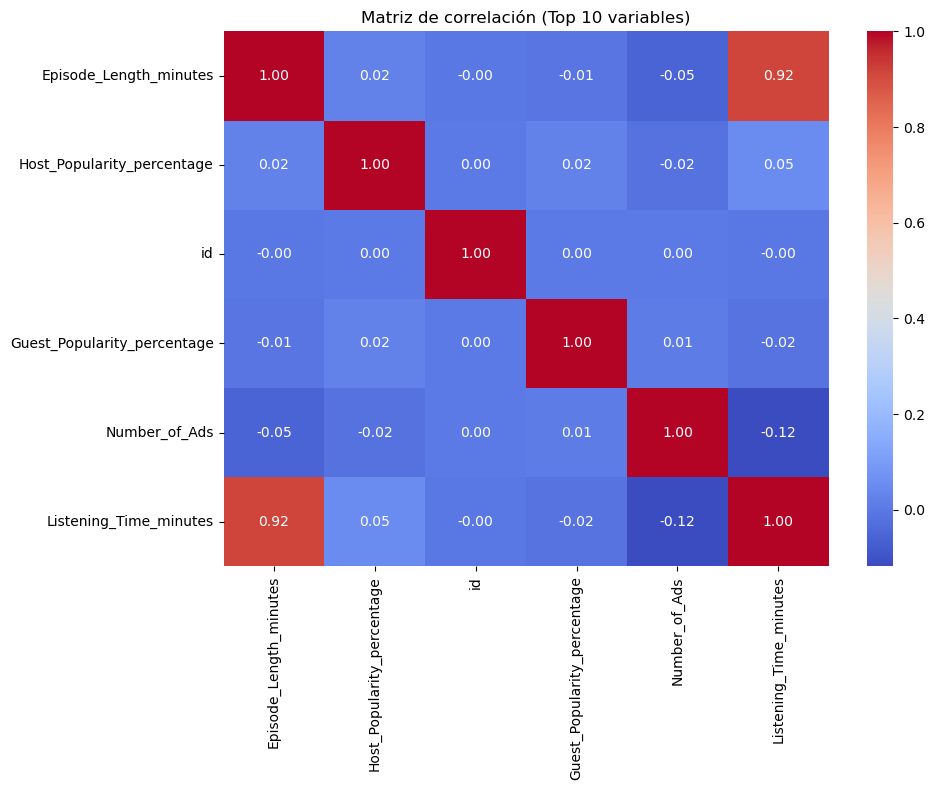

In [15]:
# Tomar las variables más correlacionadas con Listening_Time_minutes (por ejemplo, top 10)
top_features = correlaciones_ordenadas.head(10).index.tolist() + ["Listening_Time_minutes"]

plt.figure(figsize=(10, 8))
sns.heatmap(df_train[top_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación (Top 10 variables)")
plt.tight_layout()
plt.show()

In [16]:
corr_matrix = df_train.corr(numeric_only=True).abs()
high_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
             .stack()
             .sort_values(ascending=False))

# Mostrar pares con correlación mayor a 0.8
print(high_corr[high_corr > 0.8])

Episode_Length_minutes  Listening_Time_minutes    0.916749
dtype: float64


In [17]:
df_train.isnull().sum().sort_values(ascending=False)

Guest_Popularity_percentage    146030
Episode_Length_minutes          87093
Number_of_Ads                       1
id                                  0
Podcast_Name                        0
Episode_Title                       0
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [18]:
df_train.isnull().mean().sort_values(ascending=False)*100

Guest_Popularity_percentage    19.470667
Episode_Length_minutes         11.612400
Number_of_Ads                   0.000133
id                              0.000000
Podcast_Name                    0.000000
Episode_Title                   0.000000
Genre                           0.000000
Host_Popularity_percentage      0.000000
Publication_Day                 0.000000
Publication_Time                0.000000
Episode_Sentiment               0.000000
Listening_Time_minutes          0.000000
dtype: float64

In [19]:
df_train.groupby("Genre").size().sort_values(ascending=False)

Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
dtype: int64

In [20]:
df_train.groupby("Publication_Day").size().sort_values(ascending=False)

Publication_Day
Sunday       115946
Monday       111963
Friday       108237
Wednesday    107886
Thursday     104360
Saturday     103505
Tuesday       98103
dtype: int64

In [21]:
df_train.groupby("Publication_Time").size().sort_values(ascending=False)

Publication_Time
Night        196849
Evening      195778
Afternoon    179460
Morning      177913
dtype: int64

In [22]:
df_train.groupby("Episode_Sentiment").size().sort_values(ascending=False)

Episode_Sentiment
Neutral     251291
Negative    250116
Positive    248593
dtype: int64

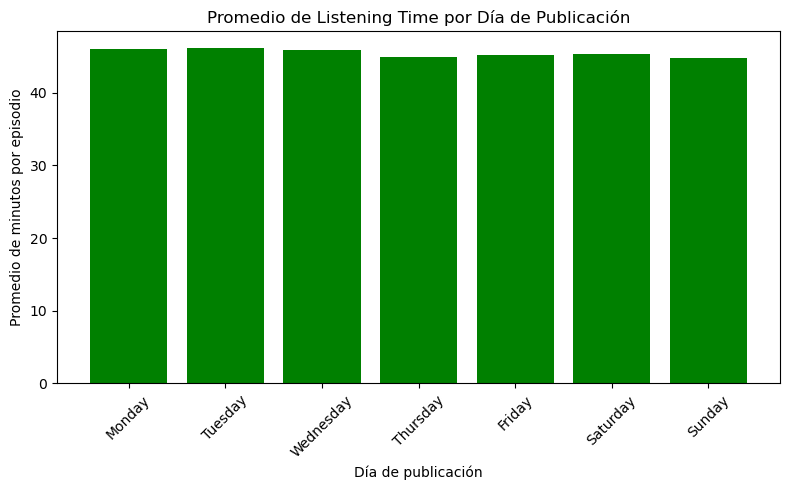

In [23]:
import matplotlib.pyplot as plt

# Agrupar
conteo_dia = df_train.groupby('Publication_Day').size()
tiempo_dia = df_train.groupby('Publication_Day')['Listening_Time_minutes'].sum()

# Calcular promedio
promedio_dia = tiempo_dia / conteo_dia

# Asegurar orden de días
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
promedio_dia = promedio_dia.reindex(orden_dias)

# Graficar
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(promedio_dia.index, promedio_dia, color='green')

ax.set_ylabel("Promedio de minutos por episodio")
ax.set_xlabel("Día de publicación")
ax.set_title("Promedio de Listening Time por Día de Publicación")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


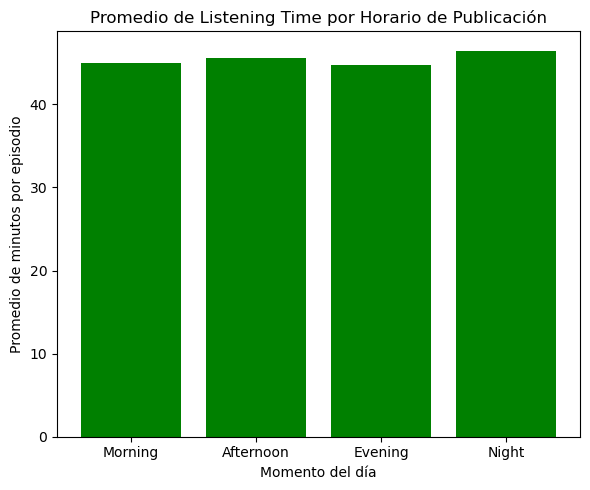

In [24]:
# Agrupar
conteo_hora = df_train.groupby('Publication_Time').size()
tiempo_hora = df_train.groupby('Publication_Time')['Listening_Time_minutes'].sum()

# Calcular promedio
promedio_hora = tiempo_hora / conteo_hora

# Orden lógico de momentos del día
orden_horas = ['Morning', 'Afternoon', 'Evening', 'Night']
promedio_hora = promedio_hora.reindex(orden_horas)

# Graficar
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(promedio_hora.index, promedio_hora, color='green')

ax.set_ylabel("Promedio de minutos por episodio")
ax.set_xlabel("Momento del día")
ax.set_title("Promedio de Listening Time por Horario de Publicación")
plt.tight_layout()
plt.show()


In [25]:
# ---------- IMPUTACIÓN EN TRAIN ----------
# Episode_Length_minutes → mediana
median_length = df_train['Episode_Length_minutes'].median()
df_train['Episode_Length_minutes'].fillna(median_length, inplace=True)

# Guest_Popularity_percentage → 0 + bandera
df_train['Guest_Popularity_percentage'].fillna(0, inplace=True)
df_train['Guest_Popularity_missing'] = df_train['Guest_Popularity_percentage'] == 0

# Number_of_Ads → mediana
df_train["Number_of_Ads"] = df_train["Number_of_Ads"].fillna(df_train["Number_of_Ads"].median())



# ---------- IMPUTACIÓN EN TEST ----------
# Usar las mismas estadísticas (¡no recalcular!)

df_test['Episode_Length_minutes'].fillna(median_length, inplace=True)
df_test['Guest_Popularity_percentage'].fillna(0, inplace=True)
df_test['Guest_Popularity_missing'] = df_test['Guest_Popularity_percentage'] == 0

# Guardás la mediana usada en train
ads_median = df_train["Number_of_Ads"].median()
# La aplicás en test
df_test["Number_of_Ads"] = df_test["Number_of_Ads"].fillna(ads_median)



C:\Users\Director escuela\AppData\Local\Temp\ipykernel_15652\162921868.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Episode_Length_minutes'].fillna(median_length, inplace=True)
C:\Users\Director escuela\AppData\Local\Temp\ipykernel_15652\162921868.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [26]:
df_train.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
Guest_Popularity_missing       0
dtype: int64

In [27]:
df_train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Guest_Popularity_missing
0,0,Mystery Matters,Episode 98,63.84,True Crime,74.81,Thursday,Night,0.00,0.0,Positive,31.41998,True
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,False
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,False
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,False


QUEDE EN LA PARTE DE SELECCIONAR LAS COLUMNAS CON LAS QUE DESEO TRABAJAR, LEUGO TRANSFORMAR LAS CATEGORICAS A NUMERICAS

In [29]:
# Eliminar columnas innecesarias
df_train.drop(["Podcast_Name", "Episode_Title"], axis=1, inplace=True)
df_test.drop(["Podcast_Name", "Episode_Title"], axis=1, inplace=True)

In [30]:
# Crear copias legibles de las columnas categóricas para visualización en Power BI

# Día de publicación: de número (0–6) a nombre del día
df_train["Publication_Day_Label"] = df_train["Publication_Day"].map({
    0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday",
    4: "Thursday", 5: "Friday", 6: "Saturday"
})

# Momento del día de publicación: 0 = Morning, ..., 3 = Night
df_train["Publication_Time_Label"] = df_train["Publication_Time"].map({
    0: "Morning", 1: "Afternoon", 2: "Evening", 3: "Night"
})

# Sentimiento del episodio: 0 = Negativo, 1 = Neutral, 2 = Positivo
df_train["Episode_Sentiment_Label"] = df_train["Episode_Sentiment"].map({
    0: "Negative", 1: "Neutral", 2: "Positive"
})

# Género del episodio (basado en tu orden exacto)
df_train["Genre_Label"] = df_train["Genre"].map({
    0: "Sports",
    1: "Technology",
    2: "True Crime",
    3: "Lifestyle",
    4: "Comedy",
    5: "Business",
    6: "Health",
    7: "News",
    8: "Music",
    9: "Education"
})

In [31]:
#TRANSFORMACION DE CATEGORICAS A NUMERICAS
categorical_cols = ["Genre", "Publication_Day", "Publication_Time", "Episode_Sentiment"]

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Transformar en train
df_train[categorical_cols] = encoder.fit_transform(df_train[categorical_cols])

# Transformar en test (sin fit)
df_test[categorical_cols] = encoder.transform(df_test[categorical_cols])

In [32]:
#No necesita codificación la columna "Guest_Popularity_missing" porque:
#Es de tipo booleano (o puede convertirse fácilmente a entero).
#Los modelos de machine learning ya la interpretan como una variable numérica binaria.
#Aun asi la transformare explícitamente a int para que no quede como bool, por claridad y control
df_train["Guest_Popularity_missing"] = df_train["Guest_Popularity_missing"].astype(int)
df_test["Guest_Popularity_missing"] = df_test["Guest_Popularity_missing"].astype(int)


In [33]:
df_train.head()

,id,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Guest_Popularity_missing,Publication_Day_Label,Publication_Time_Label,Episode_Sentiment_Label,Genre_Label
0,0,63.84,9.0,74.81,4.0,3.0,0.00,0.0,2.0,31.41998,1,NaN,NaN,NaN,NaN
1,1,119.80,1.0,66.95,2.0,0.0,75.95,2.0,0.0,88.01241,0,NaN,NaN,NaN,NaN
2,2,73.90,2.0,69.97,5.0,1.0,8.97,0.0,0.0,44.92531,0,NaN,NaN,NaN,NaN
3,3,67.17,8.0,57.22,1.0,2.0,78.70,2.0,2.0,46.27824,0,NaN,NaN,NaN,NaN
4,4,110.51,3.0,80.07,1.0,0.0,58.68,3.0,1.0,75.61031,0,NaN,NaN,NaN,NaN


In [34]:
df_train.columns

Index(['id', 'Episode_Length_minutes', 'Genre', 'Host_Popularity_percentage',
       'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage',
       'Number_of_Ads', 'Episode_Sentiment', 'Listening_Time_minutes',
       'Guest_Popularity_missing', 'Publication_Day_Label',
       'Publication_Time_Label', 'Episode_Sentiment_Label', 'Genre_Label'],
      dtype='object')

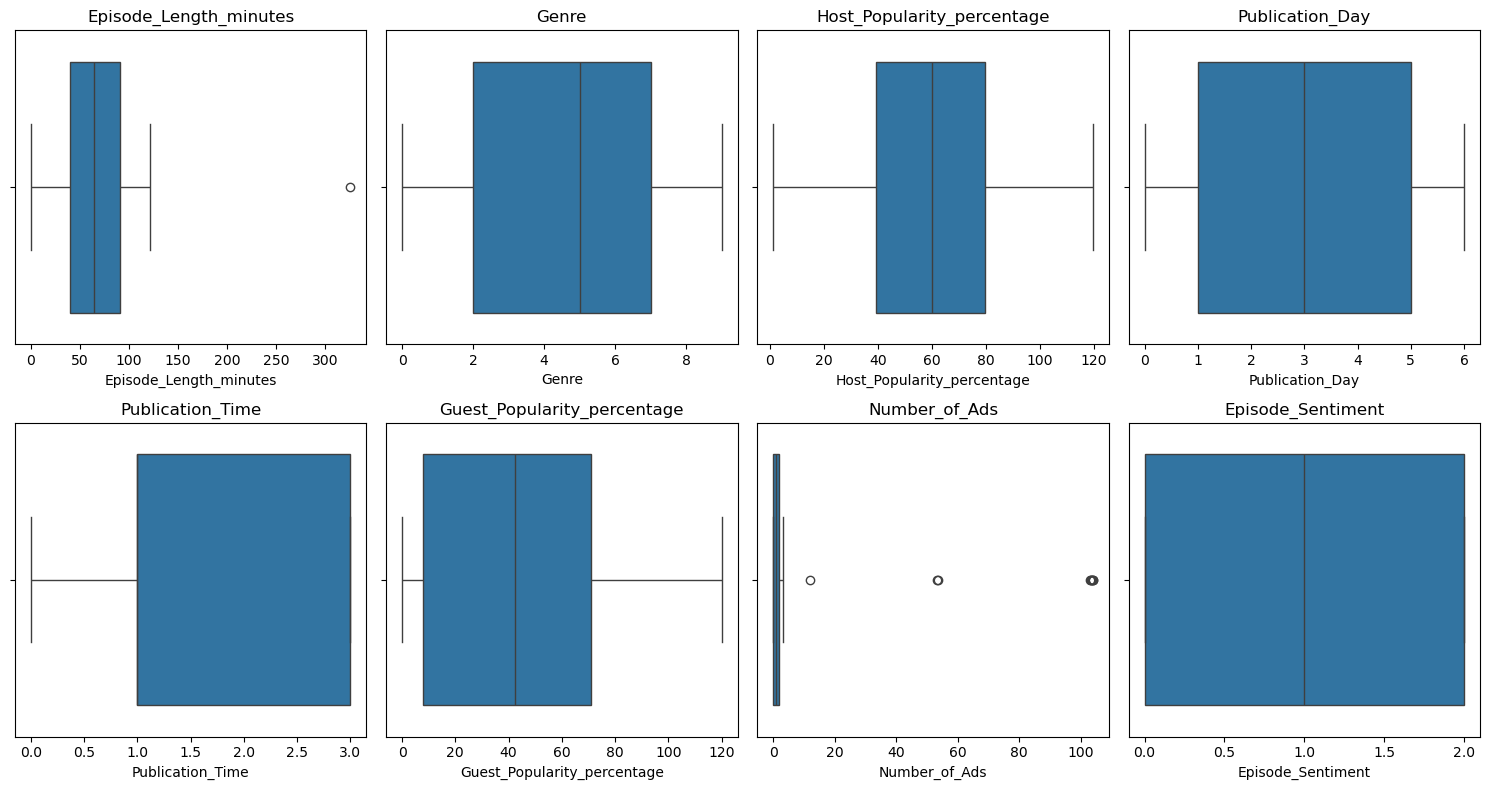

In [35]:
#REVISANDO OUTLIERS
numerical_cols = df_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ["id", "Listening_Time_minutes"]]  # target queda fuera

import matplotlib.pyplot as plt
import seaborn as sns

# Ajustar tamaño general
plt.figure(figsize=(15, 8))

# Un boxplot por cada columna numérica
for i, col in enumerate(numerical_cols):
    plt.subplot(2, (len(numerical_cols) + 1) // 2, i + 1)
    sns.boxplot(x=df_train[col])
    plt.title(col)
    plt.tight_layout()

plt.show()


In [36]:
def get_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Ejemplo para Episode_Length_minutes
low, high = get_outlier_bounds(df_train["Episode_Length_minutes"])
outliers = df_train[(df_train["Episode_Length_minutes"] < low) | (df_train["Episode_Length_minutes"] > high)]
print(f"{len(outliers)} outliers encontrados en Episode_Length_minutes")


1 outliers encontrados en Episode_Length_minutes


In [37]:
def get_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper
low_ads, high_ads = get_outlier_bounds(df_train["Number_of_Ads"])

# Filtrar los outliers
ads_outliers = df_train[
    (df_train["Number_of_Ads"] < low_ads) |
    (df_train["Number_of_Ads"] > high_ads)
]

print(f"Outliers en 'Number_of_Ads': {len(ads_outliers)} valores")
print(f"Límites aceptables: {low_ads:.2f} a {high_ads:.2f}")


Outliers en 'Number_of_Ads': 9 valores
Límites aceptables: -3.00 a 5.00


In [38]:
# Función para obtener límites IQR
def get_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

#ESTA ES LA PARTE QUE CAMBIE, ANTES TENIA CLIP ACA PARA RECORTAR. AHORA SIMPLEMENTE ELIMINO LOS OUTLIERS PERO SOLO DEL df_train,
#ESTA TECNICA NO SE APLICA EN df_test.
# Para Episode_Length_minutes
low_len, high_len = get_outlier_bounds(df_train["Episode_Length_minutes"])
df_train = df_train[(df_train["Episode_Length_minutes"] >= low_len) & (df_train["Episode_Length_minutes"] <= high_len)]

# Para Number_of_Ads
low_ads, high_ads = get_outlier_bounds(df_train["Number_of_Ads"])
df_train = df_train[(df_train["Number_of_Ads"] >= low_ads) & (df_train["Number_of_Ads"] <= high_ads)]


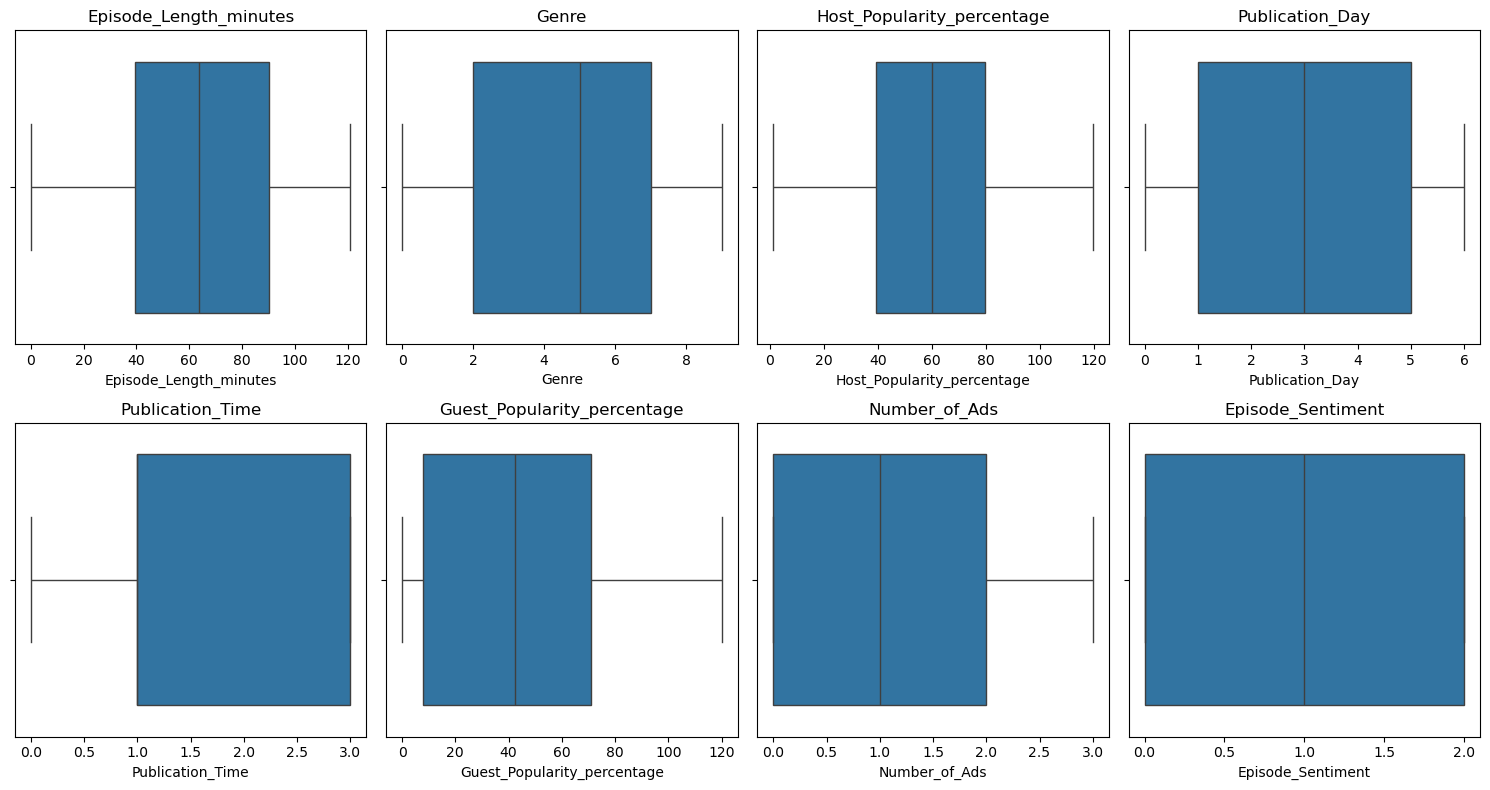

In [39]:
#REVISAndo nuevamente los outliers
numerical_cols = df_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ["id", "Listening_Time_minutes"]]  # target queda fuera

import matplotlib.pyplot as plt
import seaborn as sns

# Ajustando el TAmaño
plt.figure(figsize=(15, 8))

# Un boxplot por cada columna numérica
for i, col in enumerate(numerical_cols):
    plt.subplot(2, (len(numerical_cols) + 1) // 2, i + 1)
    sns.boxplot(x=df_train[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

**El boxplot de Guest_Popularity_missing se ve asi pq es una columna booleana o binaria y los boxplots no están hechos para datos binarios**

In [41]:
# Aqui creo nuevas variables para mejorar el desempeño del modelo
df_train["Length_per_Ad"] = df_train["Episode_Length_minutes"] / (df_train["Number_of_Ads"] + 1)
df_test["Length_per_Ad"] = df_test["Episode_Length_minutes"] / (df_test["Number_of_Ads"] + 1)

In [42]:
# Exportar dataset limpio para visualización en Power BI
df_train.to_csv("podcast_dataset_powerbi.csv", index=False)

In [ ]:
from sklearn.model_selection import train_test_split

# --- Paso 1: Separar features (X) y target (y) ---
X = df_train.drop(["id", "Listening_Time_minutes"], axis=1)
y = df_train["Listening_Time_minutes"]

# --- Paso 2: Dividir en entrenamiento y validación (80/20) ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- (Opcional) Verificar tamaños ---
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

In [ ]:
#modelo randomforest listo para entrenar
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Entrenar modelo
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predecir y evaluar
rf_preds = rf.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_preds))
print("Random Forest RMSE:", rf_rmse)


In [ ]:
#Modelo lightGBM listo para entrenar
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Entrenar el modelo
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

# Predecir en el conjunto de validación
lgbm_preds = lgbm.predict(X_val)

# Evaluar con RMSE (root mean squared error)
lgbm_rmse = np.sqrt(mean_squared_error(y_val, lgbm_preds))
print("LightGBM RMSE:", lgbm_rmse)


In [ ]:
#Aqui grafico importancia de variables para random forest
import matplotlib.pyplot as plt
import pandas as pd

# Para Random Forest
importances = rf.feature_importances_
features = X_train.columns
rf_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
rf_importance_df.sort_values(by="Importance", ascending=False).head(10)

# Gráfico
rf_importance_df.sort_values(by="Importance", ascending=True).tail(10).plot.barh(x='Feature', y='Importance', figsize=(8,5))
plt.title("Random Forest - Importancia de variables")
plt.show()


In [ ]:
#Tuning con RandomizedSearchCV para randomforest(se demora mucho)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Definir el espacio de búsqueda
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4]
}

# Randomized search
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,  # Número de combinaciones aleatorias
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entrenar búsqueda
rf_random.fit(X_train, y_train)

# Mejor modelo
best_rf = rf_random.best_estimator_
print("Mejor Random Forest:", rf_random.best_params_)


In [ ]:
#Tuning con RandomizedSearchCV apara lightGBM (se demora mucho)
from lightgbm import LGBMRegressor

lgbm_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 50],
    'min_child_samples': [5, 10, 20]
}

lgbm_random = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_distributions=lgbm_param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

lgbm_random.fit(X_train, y_train)

best_lgbm = lgbm_random.best_estimator_
print("Mejor LightGBM:", lgbm_random.best_params_)


In [ ]:
# Reentrenar con todo el set
X_full = df_train.drop(columns=["id", "Listening_Time_minutes"])
y_full = df_train["Listening_Time_minutes"]

rf_final = RandomForestRegressor(random_state=42)
rf_final.fit(X_full, y_full)

# Predecir sobre test
X_test = df_test.drop(columns=["id"])
rf_predictions = rf_final.predict(X_test)

# Crear archivo CSV
submission = pd.DataFrame({
    "id": df_test["id"],
    "Listening_Time_minutes": rf_predictions
})
submission.to_csv("submission_rf.csv", index=False)

In [ ]:
submission.head()

In [ ]:
from IPython.display import FileLink

# Generar un enlace de descarga para el archivo
FileLink("submission.csv")
